In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os 
import re
import string
from math import*
import jellyfish
import gensim
from os import path
from nltk.corpus import stopwords


In [72]:
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [4]:
import warnings
warnings.simplefilter('ignore')

In [6]:
dfnlp=pd.read_csv("D:/Stats&ML/quora-question-pairs/nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("D:/Stats&ML/quora-question-pairs/df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [13]:
STOP_WORDS = stopwords.words("english")
def remove_stop(sent):
    sent  = str(sent)
    if sent == None:
        return ' '
    if sent==np.nan:
        return ' '
    if sent == 'NaN':
        return ' '
    z = [i for i in sent.split() if i not in STOP_WORDS]
    return ' '.join(z)

In [14]:
dfnlp['question1'] = dfnlp.question1.apply(remove_stop)

In [15]:
dfnlp['question2'] = dfnlp.question2.apply(remove_stop)

In [21]:
import wget
url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
wget.download(url)

100% [....................................................................] 2176768927 / 2176768927

'glove.840B.300d.zip'

In [23]:
import zipfile
zip_ref = zipfile.ZipFile('D:/Stats&ML/quora-question-pairs/glove.840B.300d.zip', 'r')
zip_ref.extractall('D:/Stats&ML/quora-question-pairs/')
zip_ref.close()

In [24]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="D:/Stats&ML/quora-question-pairs/glove.840B.300d.txt",
               word2vec_output_file="D:/Stats&ML/quora-question-pairs/glove_vectors.txt")

(2196017, 300)

In [25]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("D:/Stats&ML/quora-question-pairs/glove_vectors.txt", binary=False)

In [26]:
def wmd(s1, s2,model):
    s1 = str(s1)
    s2 = str(s2)
    s1 = s1.split()
    s2 = s2.split()
    return model.wmdistance(s1, s2)

In [28]:
dfnlp['Word_Mover_Dist'] = dfnlp.apply(lambda x: wmd(x['question1'], x['question2'],glove_model), axis=1)

In [30]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model,d):
    '''
    Returns average of word vectors for
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [31]:
#converting into lists
list_of_question1=[]
for sent in dfnlp.question1.values:
    list_of_question1.append(sent.split())
list_of_question2=[]
for sent in dfnlp.question2.values:
    list_of_question2.append(sent.split())

In [32]:
#avg word 2 vec
avgw2v_q1 = avg_w2v(list_of_question1,glove_model,300)

In [34]:
avgw2v_q2 = avg_w2v(list_of_question2,glove_model,300)

In [36]:
#converting as df
df_avgw2v = pd.DataFrame()
df_avgw2v['q1_vec'] = list(avgw2v_q1)



In [37]:
df_avgw2v['q2_vec'] = list(avgw2v_q2)

In [47]:
len(df_avgw2v.q1_vec[0])

300

In [51]:
df_q1 = pd.DataFrame(df_avgw2v.q1_vec.values.tolist())

In [52]:
df_q2 = pd.DataFrame(df_avgw2v.q2_vec.values.tolist())

In [53]:
#importing soma distances and calculating
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock,canberra, euclidean, minkowski
dfnlp['dist_cosine'] = [cosine(x, y) for (x, y) in zip(avgw2v_q1,avgw2v_q2)]
dfnlp['dist_cityblock'] = [cityblock(x, y) for (x, y) in zip(avgw2v_q1,avgw2v_q2)]
dfnlp['dist_canberra'] = [canberra(x, y) for (x, y) in zip(avgw2v_q1,avgw2v_q2)]
dfnlp['dist_euclidean'] = [euclidean(x, y) for (x, y) in zip(avgw2v_q1,avgw2v_q2)]
dfnlp['dist_minkowski'] = [minkowski(x, y) for (x, y) in zip(avgw2v_q1,avgw2v_q2)]

In [54]:
#filling na values with 0  for cosine distance
dfnlp.dist_cosine = dfnlp.dist_cosine.fillna(0)

In [55]:
#merzing all df
df_q1.reset_index(inplace=True)
df_q2.reset_index(inplace=True)
df_q1['index'] = df_q2['index']
df_avgw2v_final = df_q1.merge(df_q2, on='index',how='left')

In [56]:
#for final df
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [57]:
##merging all 
df1.id = df_avgw2v.index
df2.id = df_avgw2v.index
df_temp = df1.merge(df2,on='id',how='left')
df_final = df_temp.merge(df_avgw2v_final,left_on='id',right_on='index',how='left')

In [58]:
df_final.head()

,id,is_duplicate,freq_qid1_x,freq_qid2_x,q1len_x,q2len_x,q1_n_words_x,q2_n_words_x,word_share_x,freq_q1+q2_x,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,1,1,66,57,"['What', 'is', 'the', 'step', 'by', 'step', 'g...","['What', 'is', 'the', 'step', 'by', 'step', 'g...",0.434783,2,...,-0.362475,0.124063,-0.038441,-0.163285,-0.012423,-0.257676,-0.200297,-0.004690,0.097588,0.160417
1,1,0,4,1,51,88,"['What', 'is', 'the', 'story', 'of', 'Kohinoor...","['What', 'would', 'happen', 'if', 'the', 'Indi...",0.200000,5,...,0.182996,0.052697,-0.047772,0.075460,0.301705,0.085308,-0.268224,0.082887,-0.008843,0.299105
2,2,0,1,1,73,59,"['How', 'can', 'I', 'increase', 'the', 'speed'...","['How', 'can', 'Internet', 'speed', 'be', 'inc...",0.166667,2,...,-0.466936,-0.142884,0.228413,0.164960,0.286664,0.061494,0.174940,0.011756,-0.400832,0.516699
3,3,0,1,1,50,65,"['Why', 'am', 'I', 'mentally', 'very', 'lonely...","['Find', 'the', 'remainder', 'when', '[math]23...",0.000000,2,...,0.217784,-0.089464,-0.184301,0.160277,-0.108320,-0.285964,-0.060224,-0.269747,0.049446,0.014591
4,4,0,3,1,76,39,"['Which', 'one', 'dissolve', 'in', 'water', 'q...","['Which', 'fish', 'would', 'survive', 'in', 's...",0.100000,4,...,-0.218490,-0.193234,-0.339956,-0.296322,-0.063324,0.334636,-0.315482,-0.412580,0.117894,-0.250972


In [59]:
#set of values
np.sort(list(set(df_final.Word_Mover_Dist.values)))

array([ 0.        ,  0.10251455,  0.11491957, ..., 12.86403772,
       13.45192544,         inf])

In [60]:
## max no after inf is 13.45 so imputed infinity with 30
df_final.Word_Mover_Dist = df_final.Word_Mover_Dist.apply(lambda x: 30 if x == np.inf else x )

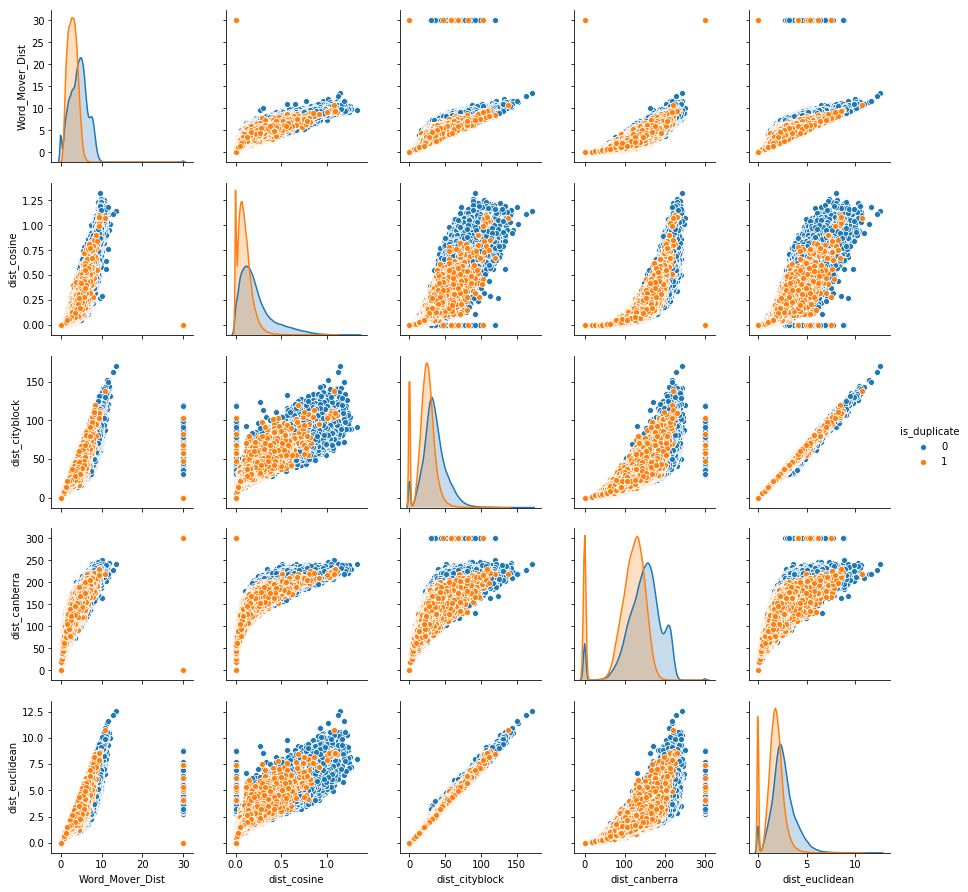

In [61]:
n = df_final.shape[0]
sns.pairplot(df_final[['Word_Mover_Dist', 'dist_cosine', 'dist_cityblock', 
                       'dist_canberra','dist_euclidean', 'is_duplicate']][0:n], 
             hue='is_duplicate', vars=['Word_Mover_Dist', 'dist_cosine', 'dist_cityblock', 'dist_canberra','dist_euclidean'])
plt.show()

In [62]:
#saving to disk
df_final.to_csv('D:/Stats&ML/quora-question-pairs/df_final_avg.csv',index=False)

In [69]:
df_final=pd.read_csv('D:/Stats&ML/quora-question-pairs/df_final_avg.csv',encoding='latin-1')

In [66]:
nan_rows = df_final[df_final.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [freq_qid1_x, freq_qid2_x, q1len_x, q2len_x, word_share_x, freq_q1+q2_x, freq_q1-q2_x, cwc_min_x, cwc_max_x, csc_min_x, csc_max_x, ctc_min_x, ctc_max_x, last_word_eq_x, first_word_eq_x, abs_len_diff_x, mean_len_x, token_set_ratio_x, token_sort_ratio_x, fuzz_ratio_x, fuzz_partial_ratio_x, longest_substr_ratio_x, Word_Mover_Dist, dist_cosine, dist_cityblock, dist_canberra, dist_euclidean, dist_minkowski, freq_qid1_y, freq_qid2_y, q1len_y, q2len_y, word_share_y, freq_q1+q2_y, freq_q1-q2_y, cwc_min_y, cwc_max_y, csc_min_y, csc_max_y, ctc_min_y, ctc_max_y, last_word_eq_y, first_word_eq_y, abs_len_diff_y, mean_len_y, token_set_ratio_y, token_sort_ratio_y, fuzz_ratio_y, fuzz_partial_ratio_y, longest_substr_ratio_y, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_

In [70]:
duplicate = df_final.is_duplicate
df_final = df_final.drop(['id','is_duplicate','index','q1_n_words_y','q1_n_words_x','q2_n_words_y','q2_n_words_x'],axis=1)

In [79]:
df_final = df_final.drop(['freq_qid1_y',
       'freq_qid2_y', 'q1len_y', 'q2len_y', 'word_share_y',
       'freq_q1+q2_y', 'freq_q1-q2_y', 'cwc_min_y', 'cwc_max_y',
       'csc_min_y', 'csc_max_y', 'ctc_min_y', 'ctc_max_y',
       'last_word_eq_y', 'first_word_eq_y', 'abs_len_diff_y',
       'mean_len_y', 'token_set_ratio_y', 'token_sort_ratio_y',
       'fuzz_ratio_y', 'fuzz_partial_ratio_y', 'longest_substr_ratio_y'],axis=1)

In [80]:
X_train,X_test, y_train, y_test = train_test_split(df_final,duplicate, stratify=duplicate, test_size=0.3,random_state=13)

In [74]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6307985865724381 Class 1:  0.36920141342756185
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [82]:
scale_col = ['freq_qid1_x', 'freq_qid2_x', 'q1len_x', 'q2len_x', 'word_share_x',
       'freq_q1+q2_x', 'freq_q1-q2_x', 'cwc_min_x', 'cwc_max_x',
       'csc_min_x', 'csc_max_x', 'ctc_min_x', 'ctc_max_x',
       'last_word_eq_x', 'first_word_eq_x', 'abs_len_diff_x',
       'mean_len_x', 'token_set_ratio_x', 'token_sort_ratio_x',
       'fuzz_ratio_x', 'fuzz_partial_ratio_x', 'longest_substr_ratio_x',
       'Word_Mover_Dist', 'dist_cosine', 'dist_cityblock',
       'dist_canberra', 'dist_euclidean', 'dist_minkowski']

In [83]:
X_train_scale = X_train[scale_col]
X_test_scale = X_test[scale_col]

In [84]:
X_train_w2v = X_train.drop(scale_col,axis=1)
X_test_w2v = X_test.drop(scale_col,axis=1)

In [85]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train_scale)
X_test_sc = scale.transform(X_test_scale)
X_train_sc = pd.DataFrame(X_train_sc,columns=X_train_scale.columns)
X_test_sc = pd.DataFrame(X_test_sc,columns=X_test_scale.columns)